# Summary
This notebook replicates the interpretation of discovered subspaces in RNA-seq data using the additional patient clinical information.

In [1]:
import sys
sys.path.append("..")

#GPU configuration
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default

import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scripts.data_generator as data_generator
import scripts.feature_ranking as feature_ranking
import scripts.features_2d as features_2d
import scripts.ga as ga
import scripts.preprocess as preprocess
import scripts.ga_evaluation as ga_evaluation
import scripts.bio_analysis as bio_analysis
import tensorflow as tf
from IPython import get_ipython
from tqdm import tqdm
from collections import Counter

plt.ion()
plt.show()

random_state=0
random.seed( random_state )
np.random.seed(random_state)

%load_ext autoreload
%autoreload 2

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
filename ="KIRP"
if filename == "KIRP":
    ground_truth_subspace = 9
else:
    ground_truth_subspace = 1

In [3]:
data = pd.read_pickle(f"../data/rna_data/{filename}.pkl")
additional_df = pd.read_pickle(f"../data/rna_data/{filename}_additional.pkl")
truth = data["y"].values
data = data.drop("y", axis = 1).values
n_clusters = len(np.unique(truth))
Counter(truth), data.shape

(Counter({0: 77, 1: 86}), (163, 17938))

In [4]:
# method = "adapted_silhouette"
# clustering = "hdbscan"

In [5]:
clustering = "gmm"
method = "adapted_ratkowsky_lance"

In [6]:
solutions = pd.read_pickle(f"../data/{filename}_{clustering}_{method}.pkl")
solutions

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.278408,-0.00,"[4332, 11017]","[1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, ...",2.0,"Counter({1: 126, 0: 37})"
1,0.278181,0.00,"[6784, 8892]","[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",2.0,"Counter({0: 125, 1: 38})"
2,0.268626,-0.00,"[181, 351, 555, 750, 812, 816, 1105, 1215, 124...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",65.0,"Counter({0: 143, 1: 20})"
3,0.310809,-0.01,"[4187, 4188, 4329, 4935, 8012, 12291, 13404, 1...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, ...",11.0,"Counter({0: 116, 1: 47})"
4,0.271371,-0.00,"[51, 163, 308, 561, 1159, 1162, 1176, 1604, 16...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",151.0,"Counter({0: 150, 1: 13})"
5,0.256949,0.01,"[7220, 7230, 7231]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0,"Counter({0: 150, 1: 13})"
6,0.234115,-0.01,"[594, 1469, 3627, 4375, 4943, 10703, 11155, 12...","[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, ...",8.0,"Counter({0: 92, 1: 71})"
7,0.237996,0.01,"[6286, 8434]","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",2.0,"Counter({0: 125, 1: 38})"
8,0.263167,0.09,"[461, 462, 466, 4625, 5126, 6138, 6267, 10770,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, ...",22.0,"Counter({0: 120, 1: 43})"
9,0.228360,0.16,"[17, 91, 943, 1884, 1994, 2016, 2454, 2813, 28...","[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...",83.0,"Counter({0: 103, 1: 60})"


In [7]:
subspaces = solutions["features"].values
partitions = solutions["partition"].values

# Number of missing clinical data


In [11]:
# (additional_df.isnull().sum()/additional_df.shape[0]).mean()

In [8]:
additional_results, best_subspace_match, best_meta_subspace = bio_analysis.clinical_data_analysis(
    additional_df, solutions, n_clusters)

Found 2 values for vital_status
Clustering numeric values for days_to_death
Clustering numeric values for days_to_last_followup
No more than 1 class found for additional_studies
Clustering numeric values for age_at_initial_pathologic_diagnosis
No more than 1 class found for b_symptoms
No more than 1 class found for bcr
Found 3 values for bcr_canonical_reason-2
No more than 1 class found for bcr_canonical_reason-3
Found 4 values for bcr_canonical_reason
Found 144 values for bcr_followup_barcode, skipping
Found 144 values for bcr_followup_uuid, skipping
Found 2 values for bcr_patient_canonical_status
Found 4 values for clinical_m
Found 5 values for clinical_n
Found 5 values for clinical_stage
Found 12 values for clinical_t
No more than 1 class found for clinical_trail_drug_classification
No more than 1 class found for day_of_dcc_upload
Clustering numeric values for day_of_form_completion
Clustering numeric values for days_to_birth
No more than 1 class found for days_to_index
No more than

In [9]:
best_subspace_match["additional_data"].unique()

array(['erythrocyte_sedimentation_rate_result', 'bcr_canonical_reason',
       'gender', 'bcr_patient_canonical_status', 'serum_calcium_result',
       'days_to_death', 'bcr_canonical_reason-2',
       'performance_status_scale_timing', 'followup_treatment_success',
       'eastern_cancer_oncology_group', 'karnofsky_performance_score'],
      dtype=object)

In [10]:
maping = {
    'breast_carcinoma_estrogen_receptor_status': "Carcinoma Estrogen Receptor",
    'metastatic_site_at_diagnosis-2': "Metastatic site 2",
    'bcr_canonical_reason': "Canonical reason",
    'anatomic_neoplasm_subdivision-4': "Neoplasm subdivision 4",
    'pos_finding_her2_erbb2_other_measurement_scale_text': "Her2 Erbb2",
    'bcr_canonical_reason-2': "Canonical reason 2",
    "days_to_additional_surgery_metastatic_procedure":
    "Days to additional surgery",
    "metastatic_site_at_diagnosis_other": "Metastatic site",
    'bcr_patient_canonical_status': "BCR Canonical Status",
    'bcr_canonical_reason-2': "BCR Canonical Reason 2",
    'erythrocyte_sedimentation_rate_result': "Erythrocyte Sedimentation",
    'gender': "Gender",
    'clinical_stage': "Clinical Stage",
    'karnofsky_performance_score': "Karnofsky performance",
    'serum_calcium_result': "Serum Calcium Result",
    'lymph_node_examined_count': "Lymph count",
    'eastern_cancer_oncology_group': "Eastern oncology group",
    'days_to_death': "Days to death",
    'year_of_tobacco_smoking_onset': "Year smoking onset",
    'followup_treatment_success': "Followup treatment success",
    'performance_status_scale_timing': "Status Scale Timing",
    "additional_surgery_locoregional_procedure": "Additional Locoregional Procedure"
}

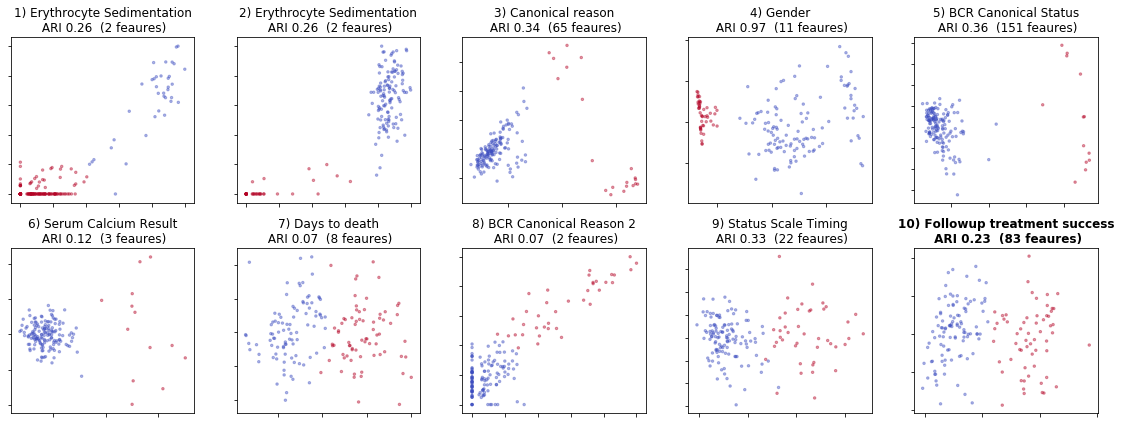

In [11]:
bio_analysis.plot_subspaces_with_best_meta(solutions,
                                           best_subspace_match,
                                           data,
                                           ground_truth_subspace,
                                           maping,
                                           do_pca=True,
                                           filename =  f"../images/{filename}_subspaces_PCA.pdf")

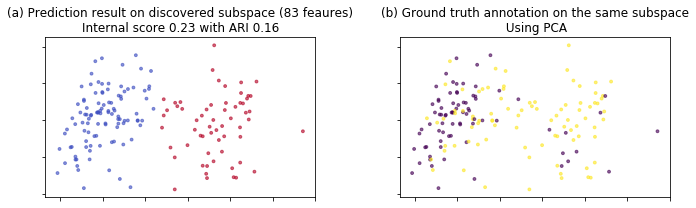

In [12]:
bio_analysis.plot_prediction_vs_ground_truth(ground_truth_subspace, solutions, data, truth, do_pca = True,
            filename = f"../images/{filename}_pred_vs_gt.pdf")


In [13]:
bio_analysis.solutions_to_survival_analysis(
    additional_df, solutions, f"../data/rna_data/{filename}_survival.pkl")

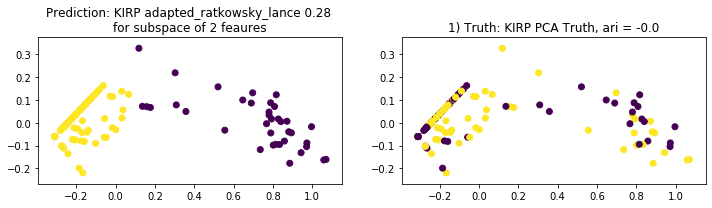

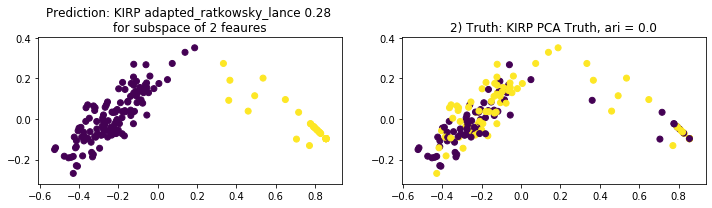

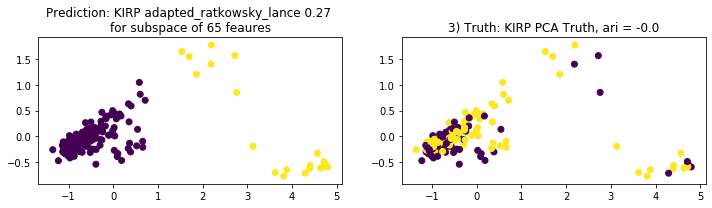

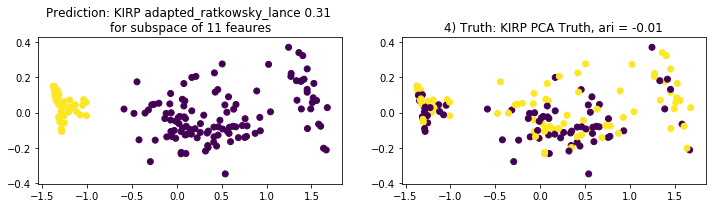

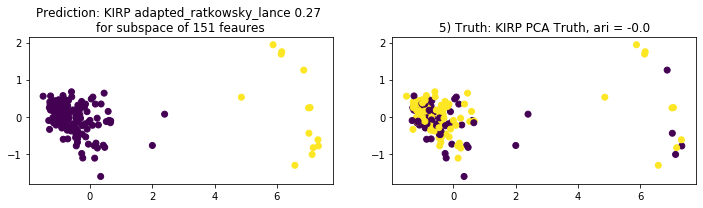

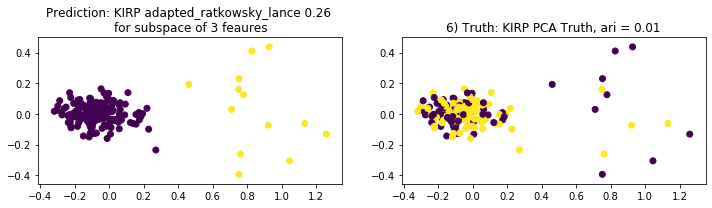

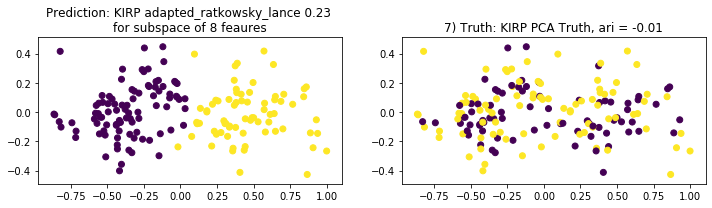

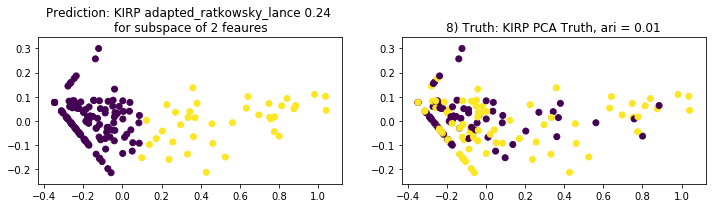

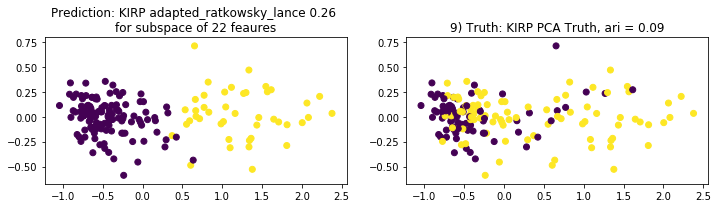

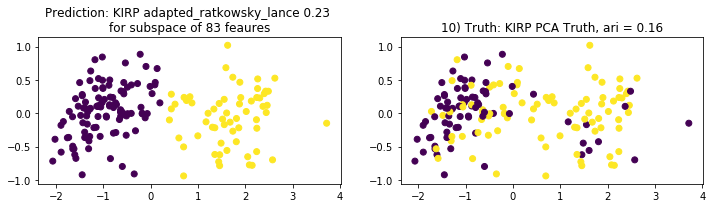

In [14]:
pdf_name =f"reports/{filename}.pdf"
bio_analysis.plot_pca_subspaces(data, solutions, method, truth, pdf_name = None, name = filename)

In [15]:
merged = bio_analysis.merge_subspaces(solutions, method, data, n_clusters, truth)

# Gender analysis

In [16]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn import cluster, datasets, mixture

In [17]:
c = 'gender'

additional_df['gender' ].isnull().sum()

not_null_idx = additional_df[~additional_df[c].isnull(
            )].index.values

labels = preprocessing.LabelEncoder().fit_transform(
                    additional_df[c].values[not_null_idx])

In [18]:
# for i in range(20):
#     print(i, adjusted_rand_score(labels, solutions.iloc[i]['partition']))

In [19]:
sid = 3

target_subspace = solutions.iloc[sid]['features']

adjusted_rand_score(labels, solutions.iloc[sid]['partition']), len(target_subspace)

(0.9746445225088622, 11)

In [20]:
labels = np.abs(labels -1)

In [21]:
mislabelled = np.where(labels!= solutions.iloc[sid]['partition'])[0]

In [22]:
len(mislabelled)

1

In [23]:
do_pca = True
data_x = data[:, target_subspace]
if do_pca:
    pca_data = PCA(n_components=2).fit_transform(data_x)
else:
    pca_data = TSNE(n_components=2).fit_transform(data_x)

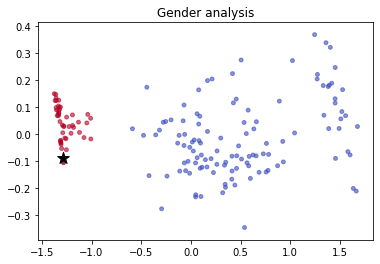

In [25]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c= solutions.iloc[sid]['partition'], 
            cmap = "coolwarm", alpha = 0.6, s = 15)
plt.scatter(pca_data[mislabelled, 0], pca_data[mislabelled, 1], c = "black", marker = '*', s =150) 
plt.title("Gender analysis")

plt.savefig("../images/gender_analysis.pdf", bbox_inches='tight')